In [1]:
from pandas import DataFrame, read_csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys 
import matplotlib 

%matplotlib inline

In [2]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.svm import OneClassSVM

In [3]:
# Read Machine Temperature Data

machineTempPath = r'C:\Users\kumar\OneDrive\Documents\Projects\Numenta\data\external\realKnownCause\realKnownCause\machine_temperature_system_failure.csv'
machineDF = pd.read_csv(machineTempPath)
machineDF.head(10)


,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
5,2013-12-02 21:40:00,78.710418
6,2013-12-02 21:45:00,80.269784
7,2013-12-02 21:50:00,80.272828
8,2013-12-02 21:55:00,80.353425
9,2013-12-02 22:00:00,79.486523


In [4]:
machineDF.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


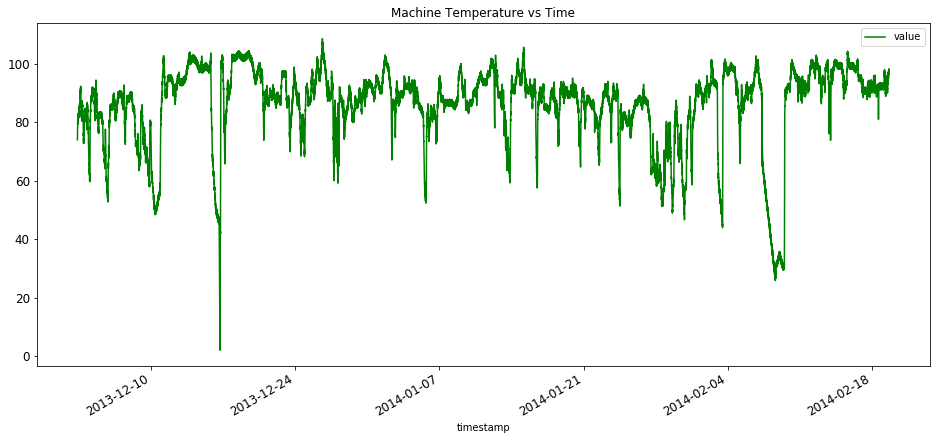

In [5]:
machineDF['timestamp'] = pd.to_datetime(machineDF['timestamp'])

# plot the data

machineDF.plot(x='timestamp', y='value',figsize=(16,7), title= 'Machine Temperature vs Time',color='Green', fontsize=12)

In [6]:
# Feature Engineering - Create additional Columns 
# Hours - Denote hour of day
# DayLight - Denote Day and Night
# Day of The Week - MTWRFSS
# WeekDay - To denote Weekday or Weekend
machineDF['Hours'] = machineDF['timestamp'].dt.hour
machineDF['Daylight'] = ((machineDF['Hours'] >= 7) & (machineDF['Hours'] <= 22)).astype(int)

machineDF['DayOfTheWeek'] = machineDF['timestamp'].dt.dayofweek
machineDF['WeekDay'] = (machineDF['DayOfTheWeek'] < 5).astype(int)
machineDF.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay
0,2013-12-02 21:15:00,73.967322,21,1,0,1
1,2013-12-02 21:20:00,74.935882,21,1,0,1
2,2013-12-02 21:25:00,76.124162,21,1,0,1
3,2013-12-02 21:30:00,78.140707,21,1,0,1
4,2013-12-02 21:35:00,79.329836,21,1,0,1


In [7]:
''' Create Categories
    WeekEndNight - Denotes weekend night
    WeekEndDay - Denotes weekend day
    WeekDayNight - Denotes weekday night
    WeekDayDay - Denotes weekday day
'''

machineDF['Categories'] = machineDF['WeekDay']*2 + machineDF['Daylight']

a = machineDF.loc[machineDF['Categories'] == 0, 'value']
b = machineDF.loc[machineDF['Categories'] == 1, 'value']
c = machineDF.loc[machineDF['Categories'] == 2, 'value']
d = machineDF.loc[machineDF['Categories'] == 3, 'value']

machineDF.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay,Categories
0,2013-12-02 21:15:00,73.967322,21,1,0,1,3
1,2013-12-02 21:20:00,74.935882,21,1,0,1,3
2,2013-12-02 21:25:00,76.124162,21,1,0,1,3
3,2013-12-02 21:30:00,78.140707,21,1,0,1,3
4,2013-12-02 21:35:00,79.329836,21,1,0,1,3


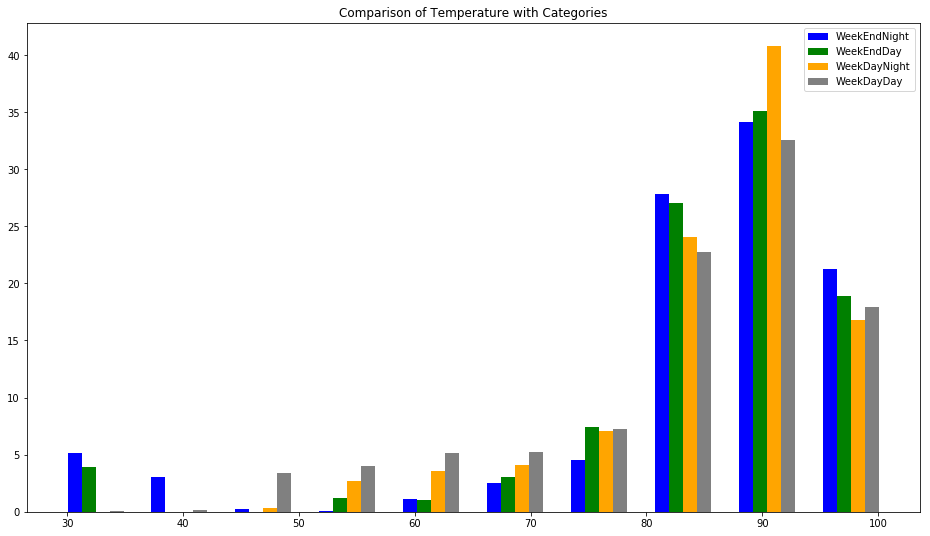

In [8]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndDay')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='orange', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='gray', label ='WeekDayDay')


fig.set_size_inches(16,9)
plt.title("Comparison of Temperature with Categories")
plt.legend()
plt.show()

In [9]:
# Anomaly Detection - Isolation Forest
data = machineDF[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = 0.05)
model.fit(data)

anomalyBasic = pd.Series(model.predict(data))
anomalyBasic = anomalyBasic.map( {1: 0, -1: 1} )
print(anomalyBasic.value_counts())

0    21556
1     1139
dtype: int64


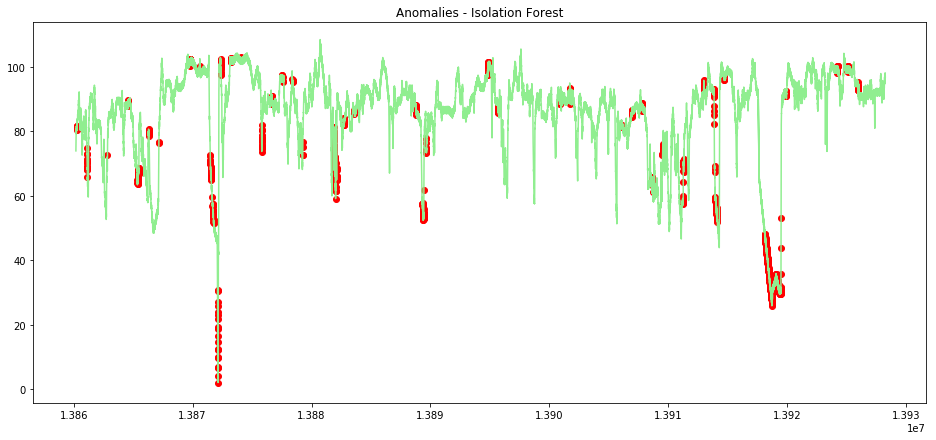

In [10]:
# Visualisation of anomaly - Isolation Forest
fig, ax = plt.subplots()

machineDF['Time'] = (machineDF['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = machineDF.loc[anomalyBasic == 1, ['Time', 'value']] #anomaly

fig.set_size_inches(16,7)
ax.plot(machineDF['Time'], machineDF['value'], color='lightgreen')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - Isolation Forest")
plt.show()

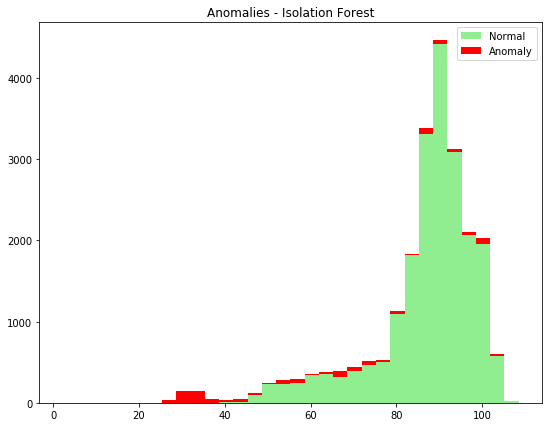

In [11]:
# visualisation of anomaly with temperature repartition (viz 2)
a = machineDF.loc[anomalyBasic == 0, 'value']
b = machineDF.loc[anomalyBasic == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['lightgreen', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

In [12]:
# Anomaly Detection - OneClassSVM

data = machineDF[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

model =  OneClassSVM(nu=0.95 * 0.05)
data = pd.DataFrame(np_scaled)
model.fit(data)

machineDF['anomalySVM'] = pd.Series(model.predict(data))
machineDF['anomalySVM'] = machineDF['anomalySVM'].map( {1: 0, -1: 1} )
print(machineDF['anomalySVM'].value_counts())

0    21617
1     1078
Name: anomalySVM, dtype: int64


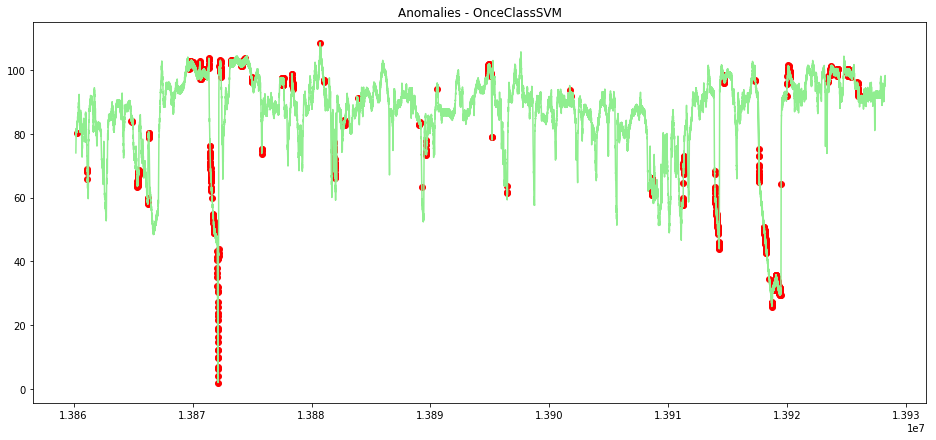

In [13]:
# Visualisation of anomaly - OneClass SVM
fig, ax = plt.subplots()

a = machineDF.loc[machineDF['anomalySVM'] == 1, ['Time', 'value']] #anomaly

fig.set_size_inches(16,7)

ax.plot(machineDF['Time'], machineDF['value'], color='lightgreen')
ax.scatter(a['Time'],a['value'], color='red')

plt.title("Anomalies - OnceClassSVM")
plt.show()

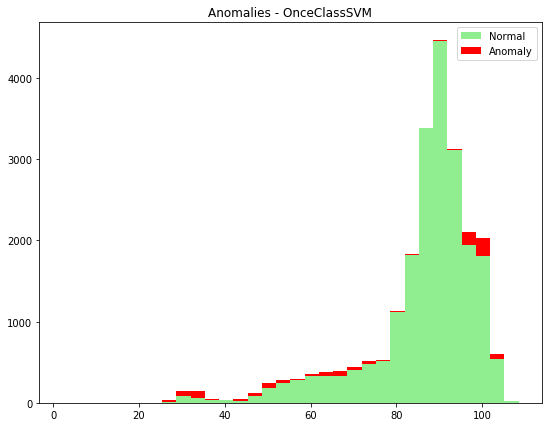

In [15]:
# visualisation of anomaly - OneClassSVM
a = machineDF.loc[machineDF['anomalySVM'] == 0, 'value']
b = machineDF.loc[machineDF['anomalySVM'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['lightgreen', 'red'], label=['Normal', 'Anomaly'])
plt.title("Anomalies - OnceClassSVM")
fig.set_size_inches(9,7)
plt.legend()
plt.show()